# Table of contents

1. Problem Description
2. Environment & Libraries
3. Data Preprocessing
4. Baseline Modeling
5. Dataset Refining
6. Logistic Regression Model
7. CNN Model
8. Unbalance problem - Solution
    - Undersampling
    - Oversampling
9. Conclusion

# 1. Problem description
The project aims to predict the diagnostics needed for a patient with certain anamnesis automatically. 

When the patient visits the doctor to get a check up, the amnesis is noted down and stored as a raw file. This file contains the patient's medical information in a free way.

The target labels are represented by the name of the needed diagnostics procedure.



# 2. Environment & Libraries

In [1]:
# Basic libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import random
import itertools
from collections import defaultdict
import sys
import os

# Preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Models

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
import lightgbm as lgb
#CNN Model
from collections import defaultdict
from bs4 import BeautifulSoup
os.environ['KERAS_BACKEND']='theano' 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from collections import Counter
from sklearn.datasets import make_classification
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
plt.switch_backend('agg')

# Evaluation

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from keras import backend as K
from keras.models import load_model
from sklearn import metrics
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# mounting the google drive to read the files (dataset and GloVE)
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# reading the mtsamples dataset
MTdata = pd.read_csv('/content/drive/My Drive/HI_Project/mtsamples.csv')
MTdata.head() # viewing the first 5 entries of the dataset

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


# 3. Data Preprocessing

In [4]:
# creating a sample variable to check the various nlp preprocessing steps
sample_text = MTdata.iloc[0,4]
sample_text

'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,

In [5]:
# only utilising the columns transcription and medical speciality as they are required for the logistic regression classifier model to predict the diagnosis
MTdata = MTdata[['transcription', 'medical_specialty']]
MTdata = MTdata.drop(MTdata[MTdata['transcription'].isna()].index) # also filtering the data set for any null values

In [6]:
# providing the count for every speciality in the dataset
MTdata['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [7]:
# checking the sentence structure

tokenizer = RegexpTokenizer(r'\w+')
MTdata["tokens"] = MTdata["transcription"].apply(tokenizer.tokenize)

# Create a list of tokens for each sentence

words_list = [word for tokens in MTdata["tokens"] for word in tokens]
sentence_len = [len(tokens) for tokens in MTdata["tokens"]]
Dictionary = sorted(list(set(words_list))) # creating a dictionary of word list
print("%s words total, with a vocabulary size of %s" % (len(words_list), len(Dictionary)))
print("Max sentence length is %s" % max(sentence_len))

2420937 words total, with a vocabulary size of 28581
Max sentence length is 3114


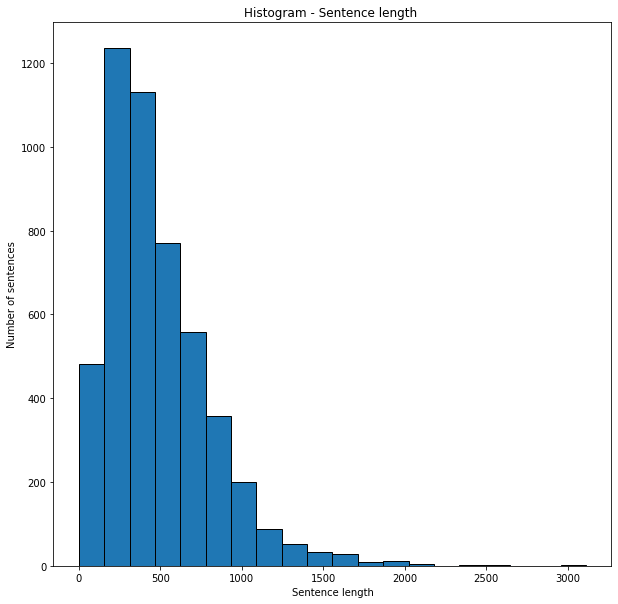

In [8]:
# creating a histogram of the number of sentences with respect to the number of words in each
fig1 = plt.figure(figsize=(10, 10)) 
plt.title('Histogram - Sentence length ')
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_len, edgecolor = 'black', bins = 20)
plt.savefig('Histogram.png')
plt.show()

In [9]:
print(f"Median sentence length {np.median(sentence_len)}")
print(f"Mean sentence length {round(np.mean(sentence_len), 2)}")

Median sentence length 421.5
Mean sentence length 487.5


<b>Text preparation

In [10]:
# creating a main function to perform tokenization, encoding and call other preprocessing functions

def preprocess(df):
    
    temp = df.copy(deep = True)
    
    temp = temp.rename(index = str, columns = {'transcription': 'text'})
    
    temp.loc[:, 'text'] = [prepare(x) for x in temp['text'].values] #Calling the prepare() 
    temp.loc[:, 'text'] = [lemmatize_text(x) for x in temp['text'].values] #Calling the lemmatize() 
    
    le = LabelEncoder() # Using Label Encoder to encode the medical specialities into digits
    le.fit(temp['medical_specialty'])
    temp.loc[:, 'class_label'] = le.transform(temp['medical_specialty'])
    
    tokenizer = RegexpTokenizer(r'\w+') # Tokenizing the transcrtiption column

    temp["tokens"] = temp["text"].apply(tokenizer.tokenize)
    
    return temp





In [11]:
def prepare(text):

    BAD_SYMBOLS = re.compile('[^0-9a-z #+_]')
    REPLACE_BY_SPACE = re.compile('[/(){}\[\]\|@,;]')
    
    STOP_WORDS = set(stopwords.words('english'))
        
    text = REPLACE_BY_SPACE.sub('', text) # replace REPLACE_BY_SPACE symbols by space in text
    text = BAD_SYMBOLS.sub('', text) # delete symbols which are in BAD_SYMBOLS from text
    text = text.lower() # convert the characters into lower case

    words = text.split()

    i = 0
    
    while i < len(words):
        if words[i] in STOP_WORDS:
            words.pop(i)
        else:
            i += 1
    text = ' '.join(map(str, words))# delete stopwords from text
    
    return text

In [12]:
# spacy instaler for 'en' used to lemmatize
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [13]:
# using nltk to fetch the list of stop words 
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# importing spacy to depict the natural language processing on a sample transcription
import spacy 
from spacy import displacy

In [15]:
nlp = spacy.load('en')

In [16]:
# performs lemmatization
def lemmatize_text(text): 
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [17]:
# Evaluation Metrics

def metrics(y_test, y_predicted):  

    precision = precision_score(y_test, y_predicted, average='weighted')             

    recall = recall_score(y_test, y_predicted, average='weighted')
    
    f1 = f1_score(y_test, y_predicted, average='weighted')
    
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [18]:
prepare_sample = prepare(sample_text)

In [19]:
# making use of a sample value to visualise the feature of spacy with respect to nlp
lemma_sample = lemmatize_text(prepare_sample)
print(type(lemma_sample))
lemma_sample = nlp(lemma_sample)
print(type(lemma_sample))
lemma_sample

<class 'str'>
<class 'spacy.tokens.doc.Doc'>


23yearold white female present complaint allergy use allergy live eattle think bad n past try laritin yrtec oth work short time seem lose effectiveness use llegra also use last summer begin use two week ago appear work well use overthecounter spray prescription nasal spray asthma do require daily medication think flare er medication currently rtho riyclen llegra know medicine allergiesital eight 130 pound blood pressure 12478 er throat mildly erythematous without exudate asal mucosa erythematous swollen nly clear drainage see cleareck upple without adenopathyungs lear llergic rhinitis1 try yrtec instead llegra nother option use loratadine think prescription coverage may cheaper2 amples asonex two spray nostril give three week prescription write well

In [20]:
# using spacy to visualize a named entity annotated transcription
displacy.render(lemma_sample, style='ent', jupyter=True)

In [21]:

# visualizing the dependency tree for the first sentenece in sample transcription

doc = nlp('subjective this 23-year - old white female present with complaint of allergy')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

Word2Vec to perform word embedding

In [22]:
# using the pretrained google news word vectors 
w2v = gensim.models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)

calling the preprocessing function and creating word embeddings.

In [23]:
# defining word2vec function so that the word vector is formed for the data which will be then used for embedding
def average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    
    if len(tokens_list)<1:
        return np.zeros(k)
    
    if generate_missing:
        word_vector = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        word_vector = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    
    length = len(word_vector)
    sum_vec = np.sum(word_vector, axis=0)
    average_vec = np.divide(sum_vec, length)
    return average_vec
    
# applying the vector notation to the text
def embeddings_word2vec(vectors, clean_tokens, generate_missing=False):
    embeddings = clean_tokens['tokens'].apply(lambda x: average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [24]:
# creating a function that makes use of the preprocessed transcript and makes a word vector for each 
def word2vec(data):
    
    new = data.copy(deep = True)    
    new = preprocess(new)
    
    embeddings = embeddings_word2vec(w2v, new)
    new_labels_list = new["class_label"].tolist()
    
    return embeddings, new_labels_list

# 4. Baseline modeling

As baseline model we'll choose LogisticRegression as one of the most verstile one. Calculating the score metrics for word2vec.

In [25]:
import nltk
nltk.download('stopwords')

# performing stratisfied k fold to retain the sample percentage
skf_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state = 42)

# multinomial class allows as there are more than two labels, also to avail cross entropy loss
log_reg_clf = LogisticRegressionCV(cv = skf_folds, solver = 'saga', 
                           multi_class = 'multinomial', n_jobs = -1, random_state = 42)

df_res = pd.DataFrame(columns = ['Preprocessing', 'Precision', 'Recall', 'F1-score', 'Accuracy'])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# Word2vec and logistic regression classifier with a test train split of 30:70
X, y = word2vec(MTdata)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.3, random_state=42)
log_reg_clf.fit(X_train_lr, y_train_lr)
y_pred = log_reg_clf.predict(X_test_lr)
accuracy, precision, recall, f1 = metrics(y_test_lr, y_pred)
df_res = df_res.append({'Preprocessing': 'Word2vec',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

In [27]:
df_res

,Preprocessing,Precision,Recall,F1-score,Accuracy
0,Word2vec,0.34784,0.38255,0.314425,0.38255


# 5. Dataset Refining

Dropping objects with number of observations less than 100.

In [28]:
counts = MTdata['medical_specialty'].value_counts()

# keeping objects with over 100 observations for better accuracy
MTdata_100 = MTdata[MTdata['medical_specialty'].isin(counts[counts > 100].index)]

In [29]:
MTdata_100['labels'] = LabelEncoder().fit_transform(MTdata_100['medical_specialty'])

In [30]:
MTdata_100['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
Name: medical_specialty, dtype: int64

# 6. Logistic Regression Model

In [31]:
# defining the logistic regression classifier model that will be used 
def log_reg(X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg, preproc):
    
    skf_folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 40)
    
    log_reg_clf = LogisticRegressionCV(cv = skf_folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
    
    log_reg_clf.fit(X_train_logreg, y_train_logreg)

    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    
    y_pred = log_reg_clf.predict(X_test_logreg)
    
    # retrieving the metrics for the model
    f1 = f1_score(y_pred, y_test_logreg, average = 'weighted')
    pres = precision_score(y_pred, y_test_logreg, average = 'weighted')
    rec = recall_score(y_pred, y_test_logreg, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_logreg)
    
    res = res.append({'Preprocessing': preproc, 'Model': f'Logistic Regression', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

In [32]:
full_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])


In [33]:
# Testing the model

X, y = word2vec(MTdata_100)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.3, random_state=42)
full_result = full_result.append(log_reg(X_train_lr, X_test_lr, y_train_lr, y_test_lr, 'Word2vec'), ignore_index = True)

full_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Word2vec,Logistic Regression,0.617946,0.483319,0.525961,0.483319


high precision score. Recall is relatively low. 

In [34]:
# model for the confusion matrix

X, y = word2vec(MTdata_100)
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(X, y, test_size=0.3, random_state=42)
skf_folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
clf_word2vec = LogisticRegressionCV(cv = skf_folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
clf_word2vec.fit(X_train_logreg, y_train_logreg)
y_pred = clf_word2vec.predict(X_test_logreg)

In [35]:
# installing lime to have a explaination of the predictions made
!pip install lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer


     |████████████████████████████████| 276kB 4.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=d42c77ba7df5ea2b51e8ad2da93074f9eb6f3a18002ff63e350220ec6935d324
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [36]:
# defining the confusion matrix function
def plot_confusion_matrix_logreg(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10, rotation = 90)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=12)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    return plt

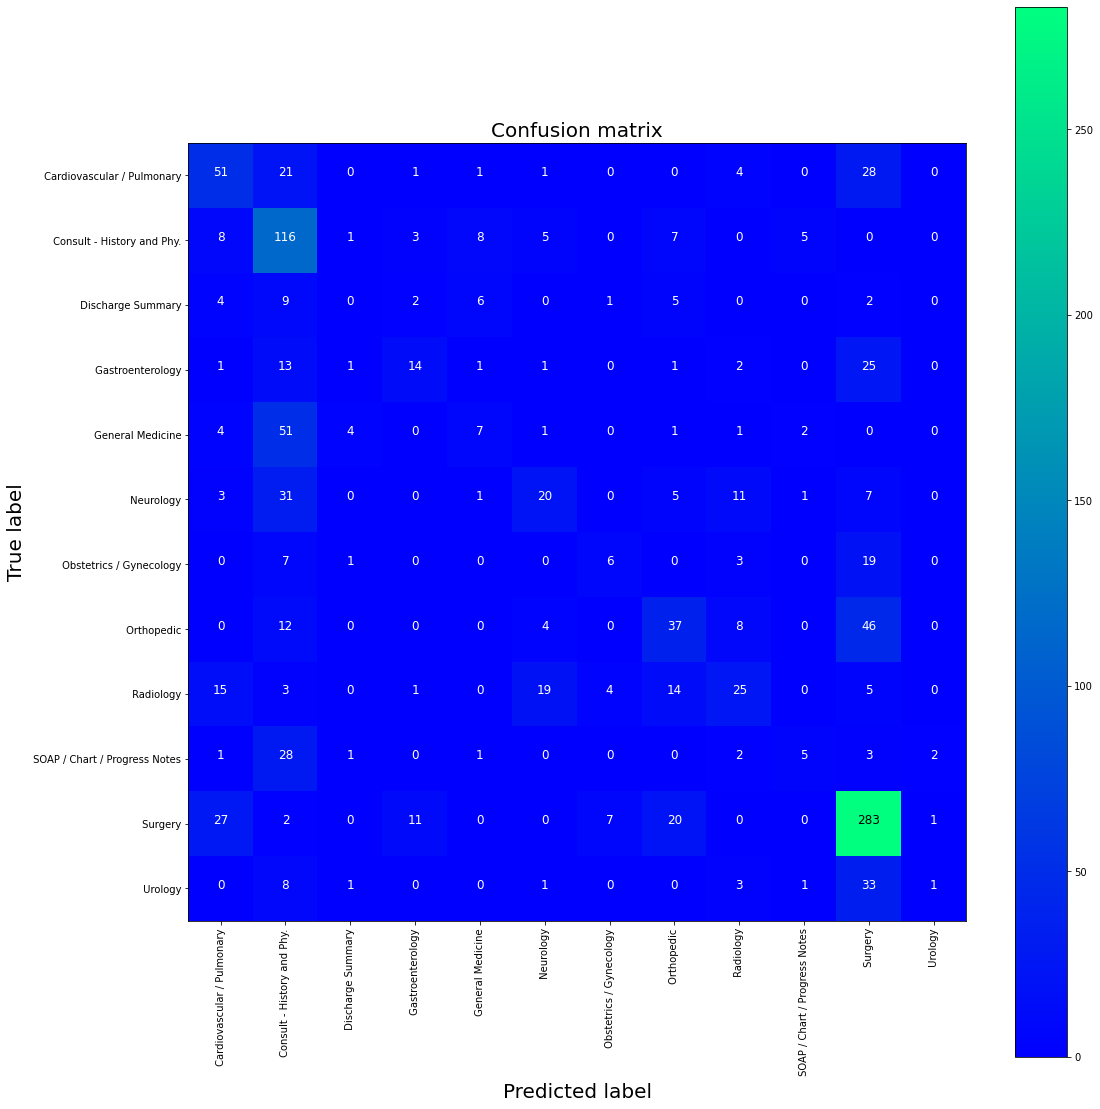

In [37]:
classes = [' Cardiovascular / Pulmonary', ' Consult - History and Phy.', ' Discharge Summary',
           ' Gastroenterology', ' General Medicine', ' Neurology', ' Obstetrics / Gynecology',
           ' Orthopedic', ' Radiology', ' SOAP / Chart / Progress Notes', ' Surgery', ' Urology']
cm = confusion_matrix(y_test_logreg, y_pred)
fig = plt.figure(figsize=(16, 16))
plot = plot_confusion_matrix_logreg(cm, classes=classes, normalize=False, 
                             title='Confusion matrix')
plt.savefig('confusion1.png')
plt.show()


We can see that classes imbalance still prevents us from getting a better result.

# 7. CNN Model

In [38]:
# Initialising the length, number of words and dimension and reading the same file
length = 1000
words = 20000
dim = 100
texts = []
labels = []
df_ml = pd.read_csv('/content/drive/My Drive/HI_Project/mtsamples.csv')

# dropping records with null value 
df_ml = df_ml.dropna()
df_ml = df_ml.reset_index(drop=True)

print('Input Shape ',df_ml.shape)
print('No. of Classes',len(set(df_ml['medical_specialty'])))
print(sorted(set(df_ml['medical_specialty'])))

Input Shape  (3898, 6)
No. of Classes 39
[' Allergy / Immunology', ' Bariatrics', ' Cardiovascular / Pulmonary', ' Chiropractic', ' Consult - History and Phy.', ' Cosmetic / Plastic Surgery', ' Dentistry', ' Dermatology', ' Diets and Nutritions', ' Discharge Summary', ' ENT - Otolaryngology', ' Emergency Room Reports', ' Endocrinology', ' Gastroenterology', ' General Medicine', ' Hematology - Oncology', ' Hospice - Palliative Care', ' IME-QME-Work Comp etc.', ' Lab Medicine - Pathology', ' Letters', ' Nephrology', ' Neurology', ' Neurosurgery', ' Obstetrics / Gynecology', ' Office Notes', ' Ophthalmology', ' Orthopedic', ' Pain Management', ' Pediatrics - Neonatal', ' Physical Medicine - Rehab', ' Podiatry', ' Psychiatry / Psychology', ' Radiology', ' Rheumatology', ' SOAP / Chart / Progress Notes', ' Sleep Medicine', ' Speech - Language', ' Surgery', ' Urology']


In [39]:
# creating individual ids for each medical speciality for the model
macronum=sorted(set(df_ml['medical_specialty']))
nid = dict((note, number) for number, note in enumerate(macronum))
def fnid(i):
    return nid[i]

df_ml['medical_specialty']=df_ml['medical_specialty'].apply(fnid)
print(sorted(set(df_ml['medical_specialty'])))
# print(df['medical_specialty'].shape)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


In [40]:
# performing necessary preprocessing steps to the dataset

def preprocess_cnn(string):
    
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\"", "", string)
    string = re.sub(r"\'", "", string)
    
    return string.strip().lower()

for index in range(df_ml.keywords.shape[0]):
    text = BeautifulSoup(df_ml.keywords[index])
    texts.append(preprocess_cnn(str(text.get_text().encode())))

for index in df_ml['medical_specialty']:
    labels.append(index)

In [41]:
# tokenizing the keywords
token = Tokenizer(num_words=length)
token.fit_on_texts(texts)
seq = token.texts_to_sequences(texts)
word_index = token.word_index
print('No. tokens: ',len(word_index))

No. tokens:  5928


In [42]:
# padding the sequences and converting the labels to categorical values

data = pad_sequences(seq, maxlen=length)
print("Input: ", data.shape)
labels = to_categorical(np.asarray(labels))
indexes = np.arange(data.shape[0])
np.random.shuffle(indexes)
data = data[indexes]
labels = labels[indexes]

# splitting the dataset to train, val and test
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=0.3, random_state=42)
xtrain2, xval, ytrain2, yval = train_test_split(xtrain, ytrain, test_size=0.3, random_state=42)


Input:  (3898, 1000)


In [43]:
# creating a word embedding using the glove file
embeddings_index = {}
f = open("/content/drive/My Drive/HI_Project/glove.6B.100d.txt",encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [44]:
# creating the embedding matrix 
embedding_matrix = np.random.random((len(word_index) + 1, dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            dim,weights=[embedding_matrix],
                            input_length=length,trainable=True)

In [45]:
# creating the custom f1 score metrics
def recall_m(orignal, predicted):
    true_positives = K.sum(K.round(K.clip(orignal * predicted, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(orignal, 0, 1)))
    recall_op = true_positives / (possible_positives + K.epsilon())
    return recall_op

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_op = true_positives / (predicted_positives + K.epsilon())
    return precision_op

def f1_m(y_true, y_pred):
    precision_op = precision_m(y_true, y_pred)
    recall_op = recall_m(y_true, y_pred)
    return 2*((precision_op*recall_op)/(precision_op+recall_op+K.epsilon()))

In [46]:
# creating a sequential model with input for shape provided
sequence_input = Input(shape=(length,), dtype='int32')

# inputting the embedding layer as the first input layer
input = embedding_layer(sequence_input)
CNN = Conv1D(32, 5, activation='relu')(input)
# CNN = Conv1D(32, 5, activation='relu')(CNN)
#CNN = BatchNormalization()(CNN)
CNN = MaxPooling1D(5)(CNN)
#CNN = Dropout(0.2)(CNN)

CNN = Conv1D(64, 5, activation='relu')(CNN)
# CNN = Conv1D(128, 5, activation='relu')(CNN)
#CNN = BatchNormalization()(CNN)
CNN = MaxPooling1D(5)(CNN)
#CNN = Dropout(0.2)(CNN)

CNN = Conv1D(96, 5, activation='relu')(CNN)
# CNN = Conv1D(256, 5, activation='relu')(CNN)
# CNN = Conv1D(256, 5, activation='relu')(CNN)
#CNN = BatchNormalization()(CNN)
CNN = MaxPooling1D(5)(CNN)
CNN = Dropout(0.2)(CNN)

CNN = Flatten()(CNN)

CNN = Dropout(0.2)(CNN)
CNN = Dense(128, activation='relu')(CNN)

CNN = Dropout(0.2)(CNN)
# CNN = Dense(128, activation='relu')(CNN)

# l_dense1 = Dense(128, activation='relu')(l_dense)
preds = Dense(len(macronum), activation='softmax')(CNN)

model = Model(sequence_input, preds)

# model is created to have categorical cross entropy as the labels are encoded and metrics are F1 score which have been initialised earlier
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc',f1_m,precision_m, recall_m])

model.save('CNN.hdf5')
print("CNN")
model.summary()

# plot_model is used to visualise the cnn model 
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# checkpoints are created so that weights are saved and can be loaded to test the model with test data
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)


CNN
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         592900    
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 32)           16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 64)           10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 96)       

In [47]:
# model is run with 7 epochs
history=model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=7, batch_size=2, callbacks=[cp])

Epoch 1/7
1364/1364 [==============================] - ETA: 0s - loss: 2.2593 - acc: 0.3776 - f1_m: 0.3087 - precision_m: 0.4157 - recall_m: 0.2551
Epoch 00001: val_acc improved from -inf to 0.62149, saving model to model_cnn.hdf5
1364/1364 [==============================] - 27s 20ms/step - loss: 2.2593 - acc: 0.3776 - f1_m: 0.3087 - precision_m: 0.4157 - recall_m: 0.2551 - val_loss: 1.4448 - val_acc: 0.6215 - val_f1_m: 0.6163 - val_precision_m: 0.7805 - val_recall_m: 0.5341
Epoch 2/7
1363/1364 [============================>.] - ETA: 0s - loss: 1.2413 - acc: 0.6511 - f1_m: 0.6689 - precision_m: 0.8144 - recall_m: 0.5961
Epoch 00002: val_acc improved from 0.62149 to 0.75702, saving model to model_cnn.hdf5
1364/1364 [==============================] - 27s 20ms/step - loss: 1.2404 - acc: 0.6514 - f1_m: 0.6691 - precision_m: 0.8145 - recall_m: 0.5964 - val_loss: 0.8684 - val_acc: 0.7570 - val_f1_m: 0.7866 - val_precision_m: 0.9256 - val_recall_m: 0.7171
Epoch 3/7
1363/1364 [================

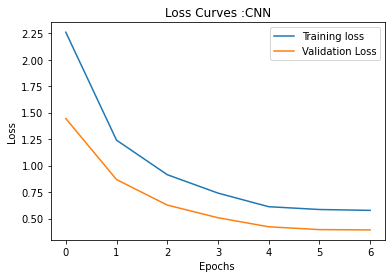

In [48]:
# loss curve
fig1=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Loss Curves :CNN')
fig1.savefig('Loss_cnn.png')
plt.show(fig1)

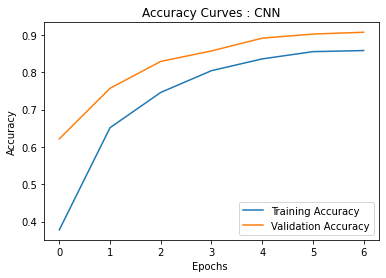

In [49]:
# accuracy curve
fig2=plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs ')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves : CNN')
fig2.savefig('accuracy_cnn.png')
plt.show(fig2)

<b>Model Testing</b>

In [50]:

model.load_weights("model_cnn.hdf5")


In [51]:
model.evaluate(xtest, ytest)

37/37 [==============================] - 1s 34ms/step - loss: 0.4797 - acc: 0.8906 - f1_m: 0.9246 - precision_m: 0.9950 - recall_m: 0.8659


[0.47972527146339417,
 0.8905982971191406,
 0.9245938658714294,
 0.994986355304718,
 0.8658971190452576]

# 8. Unbalance problem - Solution



There are several ways to fight imbalance:

1. Undersampling
2. Oversampling

Undersampling is cutting off some observations of the major classes to make them more comparable in count with the minor ones. Due to the amount of data we have, such approach might not be profitable, as we make the amount of data even smaller, which might affect model quality. But still we can try.
Simple random drop of some observations share based on the assumption that dropping some samples will not affect he distribution. Randomness of the samples pick and small amount of data doesn't ensure it. So we need to apply more complex methods.

Oversampling, counterwise to undersampling, is adding more copies of observations from minor classes to straighted classes distribution. As we are working with text data, doubling some samples will probably lead to overfitting on these samples. So, just like in the case of undersampling we will need more complex approach.

In [52]:
naive_underSample = RandomUnderSampler(sampling_strategy = 'majority')

X, y = naive_underSample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Modified set observations 2914
Modified set target classes 12


In [53]:
# DataFrame for result evaluation

naive_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

naive_underSample = RandomUnderSampler(sampling_strategy = 'majority')

In [54]:

# Testing Word2vec

X, y = word2vec(MTdata_100)
X, y = naive_underSample.fit_resample(X, y)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.3, random_state=42)
naive_result = naive_result.append(log_reg(X_train_lr, X_test_lr, y_train_lr, y_test_lr, 'Word2vec'), ignore_index = True)

In [55]:
naive_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Word2vec,Logistic Regression,0.612433,0.499429,0.535144,0.499429


One can see, that naive approach didn't make any significant gain in metrics. Recall became better in overall, but precision dropped. F1-score therefore slightly decreased.
Using NearMiss method alternatively.

In [56]:
near_underSample = NearMiss(sampling_strategy='majority')

X, y = near_underSample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Modified set observations 2506
Modified set target classes 12


In [57]:
# DataFrame for result evaluation

near_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

near_underSample = NearMiss(sampling_strategy='majority')

In [58]:
# Testing Word2vec

X, y = word2vec(MTdata_100)
X, y = near_underSample.fit_resample(X, y)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.3, random_state=42)
near_result = near_result.append(log_reg(X_train_lr, X_test_lr, y_train_lr, y_test_lr, 'Word2vec'), ignore_index = True)

In [59]:
near_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Word2vec,Logistic Regression,0.614845,0.499429,0.534958,0.499429


NearMiss method gave almost the same result as naive approach.
Applying SMOTE over sampling and checking the scores againg

In [60]:
smote_overSample = SMOTE(sampling_strategy='minority')

X, y = smote_overSample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Modified set observations 3322
Modified set target classes 12


In [61]:
# DataFrame for result evaluation

smote_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

smote_overSample = SMOTE(sampling_strategy='minority')

# Testing Word2vec

X, y = word2vec(MTdata_100)
X, y = smote_overSample.fit_resample(X, y)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.3, random_state=42)
smote_result = smote_result.append(log_reg(X_train_lr, X_test_lr, y_train_lr, y_test_lr, 'Word2vec'), ignore_index = True)

In [62]:
smote_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Word2vec,Logistic Regression,0.678548,0.545455,0.595029,0.545455


SMOTE generated oversampling procedure gave a huge leap in quality. More importantly - the quality have got gain in every direction, including both precision and recall.


Best model of all we have received is word2vec on SMOTE trained on Logistic Regression.

Let's look at its confusion matrix.

In [63]:
X, y = word2vec(MTdata_100)
X, y = smote_overSample.fit_resample(X, y)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.3, random_state=42)
clf_word2vec_smote = LogisticRegressionCV(cv = skf_folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
clf_word2vec_smote.fit(X_train_smote, y_train_smote)
y_pred = clf_word2vec_smote.predict(X_test_smote)

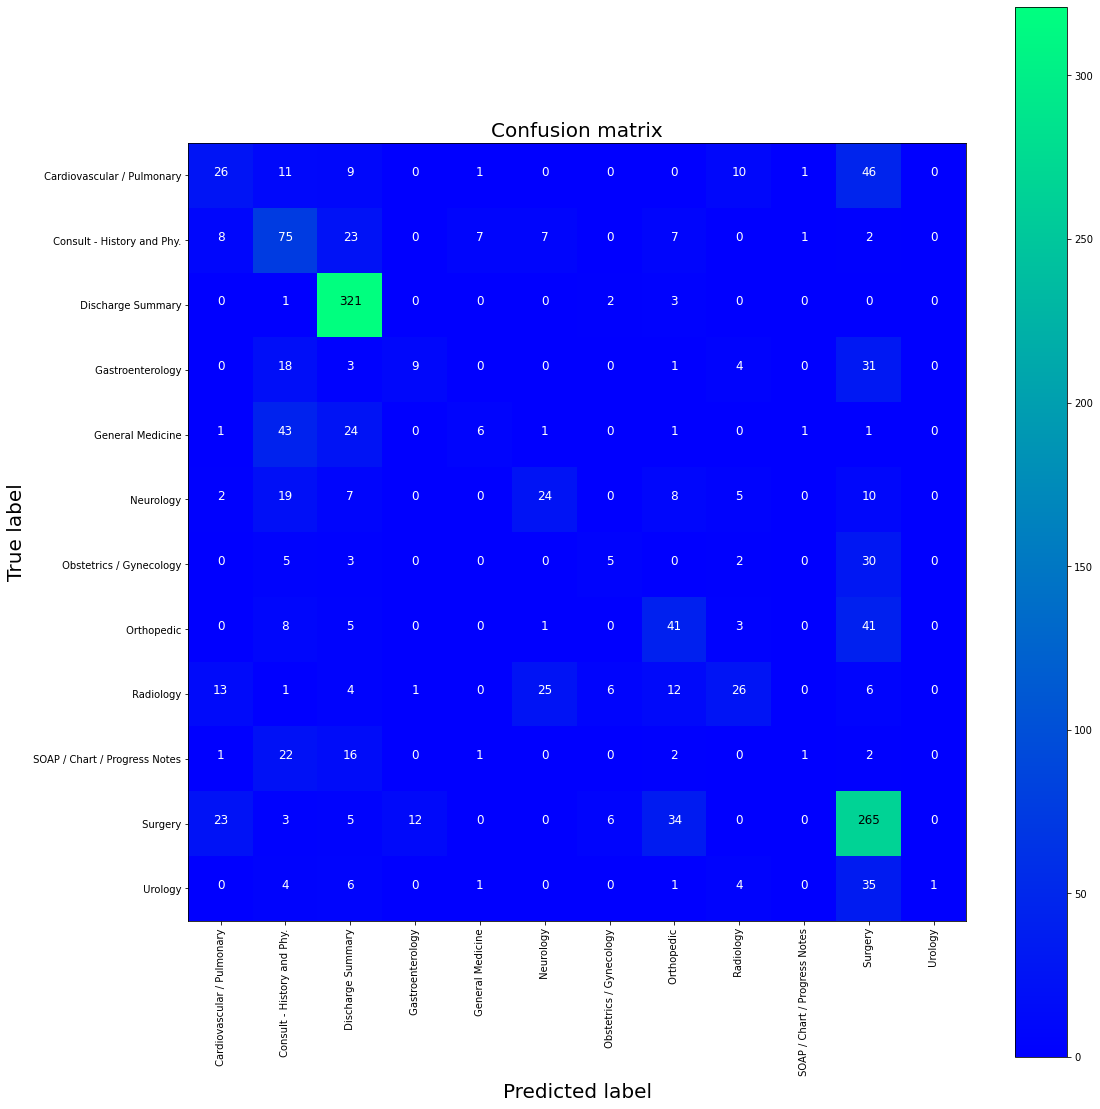

In [64]:
cm = confusion_matrix(y_test_smote, y_pred)
fig = plt.figure(figsize=(16, 16))
plot = plot_confusion_matrix_logreg(cm, classes=classes, normalize=False, 
                             title='Confusion matrix')
plt.savefig('confusion2.png')
plt.show()


One way to see how the model works is to manually watch at the most valuable and the least valuable words for the class.

In [65]:
store_vector = w2v

# creating a pipeline for the word2vec flow so that the lime functionality can be used to predict important words
def word2vec_flow(values):
    global store_vector
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for value in values:
        value_tokens = tokenizer.tokenize(value)
        wv_vectorized = average_word2vec(value_tokens, store_vector, generate_missing=False, k=300)
        tokenized_list.append(wv_vectorized)
    return clf_word2vec.predict_proba(tokenized_list)

c = make_pipeline(CountVectorizer(), log_reg_clf)

random.seed(40) # to create a random sequence 

#applying preprocessing () to the data for this explaination
MTdata_100_prep = preprocess(MTdata_100)
dict_list = MTdata_100_prep["text"].tolist()
labels_list = MTdata_100_prep["class_label"].tolist()

# splitting the dataset which will be used to predict the important words later
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(dict_list, labels_list, test_size=0.3, 
                                                                                random_state=42)
# defining a function to make use of lime explainer
def statistic(test_set, sample_size, word2vec_flow, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_flow([sentence])
        label_initial = probabilities[0].argmax()
        labels_to_sentences[label_initial].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_flow, num_features=6, labels=[label_initial])
        listed_explanation = exp.as_list(label=label_initial)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[label_initial]:
                contributors[label_initial][word].append(contributing_weight)
            else:
                contributors[label_initial][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_word_value = {}
    sorted_word_value = {}
    for label,lexica in contributors.items():
        label_initial = label
        curr_lexica = lexica
        average_word_value[label_initial] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_word_value[label_initial].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_word_value[label_initial].sort_values()
        supporters = average_word_value[label_initial].sort_values(ascending=False)
        sorted_word_value[label_dict[label_initial]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_word_value

label_to_text = {
    0: ' Cardiovascular / Pulmonary',
    1: ' Consult - History and Phy.',
    2: ' Discharge Summary',
    3: ' Gastroenterology',
    4: ' General Medicine',
    5: ' Neurology',
    6: ' Obstetrics / Gynecology',
    7: ' Orthopedic',
    8: ' Radiology',
    9: ' SOAP / Chart / Progress Notes',
    10: ' Surgery',
    11: ' Urology'
}
sorted_word_value = statistic(X_test_data, 100, word2vec_flow, label_to_text)

In [66]:
final_metrics = pd.DataFrame({'Labels': range(12), 
                              'Recall': recall_score(y_pred, y_test_smote, average = None),
                             'Precision': precision_score(y_pred, y_test_smote, average = None),
                             'F1-score': f1_score(y_pred, y_test_smote, average = None)})
final_metrics['Labels'] = final_metrics['Labels'].replace(label_to_text)
final_metrics

,Labels,Recall,Precision,F1-score
0,Cardiovascular / Pulmonary,0.351351,0.250000,0.292135
1,Consult - History and Phy.,0.357143,0.576923,0.441176
2,Discharge Summary,0.753521,0.981651,0.852590
3,Gastroenterology,0.409091,0.136364,0.204545
4,General Medicine,0.375000,0.076923,0.127660
5,Neurology,0.413793,0.320000,0.360902
6,Obstetrics / Gynecology,0.263158,0.111111,0.156250
7,Orthopedic,0.372727,0.414141,0.392344
8,Radiology,0.481481,0.276596,0.351351
9,SOAP / Chart / Progress Notes,0.250000,0.022222,0.040816


The result is still not perfect, but yet it is much better, than it was in the beginning. Some classes are recognized pretty well.


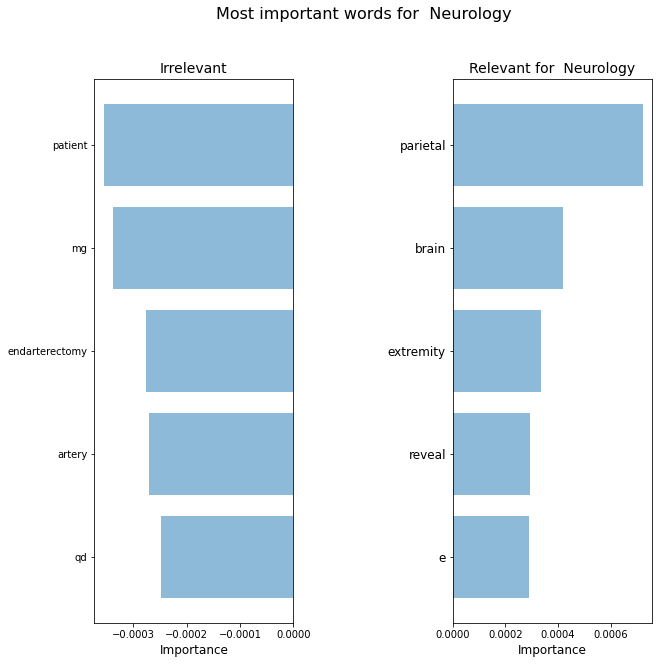

In [67]:
def important_word_plot(top_scores, most_important_word, bottom_scores, least_important_word, name):
    y_pos = np.arange(len(most_important_word))
    important_word_pairs = [(a,b) for a,b in zip(most_important_word, top_scores)]
    important_word_pairs = sorted(important_word_pairs, key=lambda x: x[1])
    
    least_important_word_pairs = [(a,b) for a,b in zip(least_important_word, bottom_scores)]
    least_important_word_pairs = sorted(least_important_word_pairs, key=lambda x: x[1], reverse=True)
    
    most_important_word = [a[0] for a in important_word_pairs]
    top_scores = [a[1] for a in important_word_pairs]
    
    least_important_word = [a[0] for a in least_important_word_pairs]
    bottom_scores = [a[1] for a in least_important_word_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=14)
    plt.yticks(y_pos, least_important_word, fontsize=10)
    plt.suptitle('Key words', fontsize=12)
    plt.xlabel('Importance', fontsize=12)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title("Relevant for " + name, fontsize=14)
    plt.yticks(y_pos, most_important_word, fontsize=12)
    plt.suptitle(f"Most important words for {name}", fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

test_label = ' Neurology'
most_important_word = sorted_word_value[test_label]['supporters'][:5].index.tolist()
top_scores = sorted_word_value[test_label]['supporters'][:5].tolist()
least_important_word = sorted_word_value[test_label]['detractors'][:5].index.tolist()
bottom_scores = sorted_word_value[test_label]['detractors'][:5].tolist()

important_word_plot(top_scores, most_important_word, bottom_scores, least_important_word, test_label)

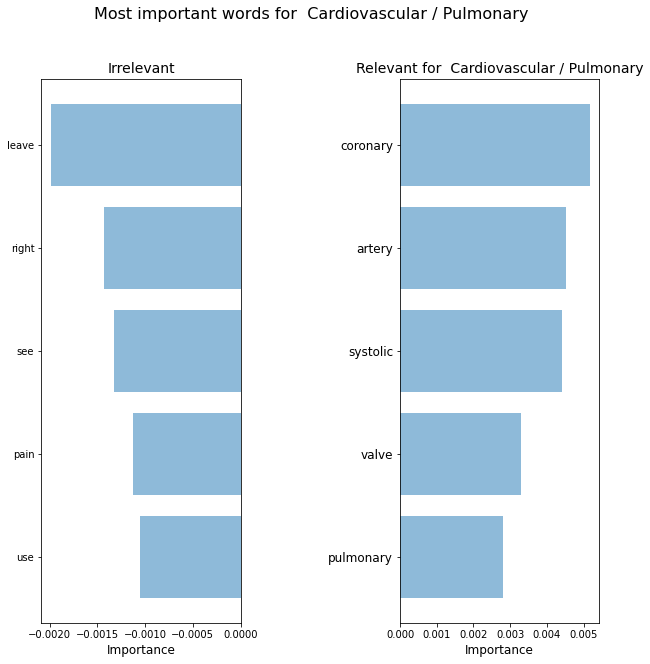

In [68]:
test_label = ' Cardiovascular / Pulmonary'
most_important_word = sorted_word_value[test_label]['supporters'][:5].index.tolist()
top_scores = sorted_word_value[test_label]['supporters'][:5].tolist()
least_important_word = sorted_word_value[test_label]['detractors'][:5].index.tolist()
bottom_scores = sorted_word_value[test_label]['detractors'][:5].tolist()

important_word_plot(top_scores, most_important_word, bottom_scores, least_important_word, test_label)

In [69]:
smote_result['F1-score']

0    0.595029
Name: F1-score, dtype: float64

In [70]:
import pickle
# saving the knn model to a pickle file
with open('smote_log.pkl', 'wb') as f:
    pickle.dump(clf_word2vec_smote, f)

# loading the saved file
with open('smote_log.pkl', 'rb') as f:
    logreg_clf = pickle.load(f)

In [71]:
logreg_clf.fit(X_test_smote, y_test_smote)

LogisticRegressionCV(Cs=10, class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='saga', tol=0.0001, verbose=0)

In [72]:
y_pred_logreg = logreg_clf.predict(X_test_smote)

In [73]:
print("\nConfusion Matrix Log Reg with Smote\n",confusion_matrix(y_test_smote, y_pred_logreg))
print("\nConfusion Report Log Reg with Smote\n",classification_report(y_test_smote, y_pred_logreg))


Confusion Matrix Log Reg with Smote
 [[ 45  11   5   0   1   0   0   0   6   0  36   0]
 [  4  81   9   0  11   8   0   6   3   4   2   2]
 [  0   0 322   0   0   1   0   4   0   0   0   0]
 [  0  12   1  28   2   0   0   0   0   0  23   0]
 [  0  18  16   0  34   2   0   2   1   4   1   0]
 [  0   7   5   0   0  43   0   3   8   0   9   0]
 [  0   5   2   0   0   0  16   0   1   0  21   0]
 [  0   3   3   0   0   1   0  44   9   0  39   0]
 [  4   0   0   0   0  14   1   2  68   0   5   0]
 [  1   5   8   0   5   0   0   2   1  22   1   0]
 [ 15   0   3  11   0   0   5  13   0   0 296   5]
 [  0   4   3   0   0   0   0   0   2   0  20  23]]

Confusion Report Log Reg with Smote
               precision    recall  f1-score   support

           0       0.65      0.43      0.52       104
           1       0.55      0.62      0.59       130
           2       0.85      0.98      0.91       327
           3       0.72      0.42      0.53        66
           4       0.64      0.44      0

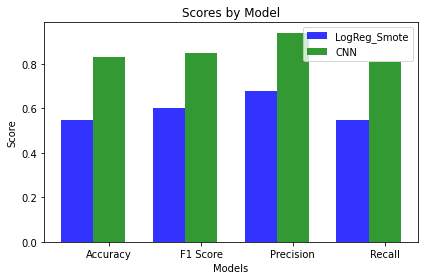

In [74]:
# creating a bar plot for comparing CNN and Logistic Regression models

# data to plot
n_groups = 4
LogReg_Smote = (0.54, 0.59, 0.67, 0.54)
CNN = (0.85, 0.88, 0.95, 0.84)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, LogReg_Smote, bar_width,
alpha=opacity,
color='b',
label='LogReg_Smote')

rects2 = plt.bar(index + bar_width, CNN, bar_width,
alpha=opacity,
color='g',
label='CNN')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Scores by Model')
plt.xticks(index + bar_width, ('Accuracy', 'F1 Score', 'Precision', 'Recall'))
plt.legend()

plt.tight_layout()
plt.savefig('Comparison.png')
plt.show()


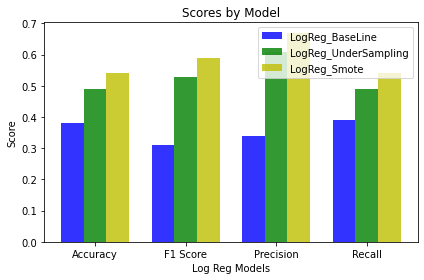

In [81]:
# creating a bar plot for comparing Logistic Regression models

# data to plot
n_groups = 4
LogReg_BaseLine = (0.38, 0.31, 0.34, 0.39)
LogReg_UnderSampling = (0.49, 0.53, 0.61, 0.49)
LogReg_Smote = (0.54, 0.59, 0.67, 0.54)


# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

lr_rects1 = plt.bar(index, LogReg_BaseLine, bar_width,
alpha=opacity,
color='b',
label='LogReg_BaseLine')

lr_rects2 = plt.bar(index + bar_width, LogReg_UnderSampling, bar_width,
alpha=opacity,
color='g',
label='LogReg_UnderSampling')

lr_rects3 = plt.bar(index + bar_width + bar_width, LogReg_Smote, bar_width,
alpha=opacity,
color='y',
label='LogReg_Smote')



plt.xlabel('Log Reg Models')
plt.ylabel('Score')
plt.title('Scores by Model')
plt.xticks(index + bar_width, ('Accuracy', 'F1 Score', 'Precision', 'Recall'))
plt.legend()

plt.tight_layout()
plt.savefig('Comparison_logreg.png')
plt.show()


# 9. Conclusion

This project schowcases an attempt to build an algorithm, which would predict necessary diagnostics for a patient based on his anamnesis. Two models are compared (Logistic Regression and CNN). From basic f1-score of around 0.32 using logistic regression, it was managed to increase capability of the algorithm up to nearly 0.60 using Smote Over sampling.
CNN was capable of producing an F1 score of 0.83 when compared to logistic model without any such sampling.
Although, it barely can be used in real-life diagnostics, it is a minor step in helping out with some minor adjuscent fields. Analysing some popular words-triggers for different diseases in scientific or applied purposes, optimisation of medical facility schedule or a way of preliminary patient analysis could be done in order to desrease the list of potential diagnostics.

